In [33]:
# Author: Matt Williams
# Version: 2/1/2023

# Dataset = https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset

import os
import pandas
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt
import sys
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
import numpy as np


CWD = os.path.abspath(os.getcwd())
STROKE_CSV = os.path.join(CWD, "healthcare-dataset-stroke-data.csv")

print(f"System version: {sys.version}")

System version: 3.10.2 (tags/v3.10.2:a58ebcc, Jan 17 2022, 14:12:15) [MSC v.1929 64 bit (AMD64)]


In [34]:
# reading in the file and checking information
stroke_df = pandas.read_csv(STROKE_CSV, index_col=None)
print(f"Columns: {stroke_df.columns.tolist()}")
print(stroke_df.shape)
print(stroke_df.head())

Columns: ['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'avg_glucose_level', 'bmi', 'smoking_status', 'stroke']
(5110, 12)
      id  gender   age  hypertension  heart_disease ever_married  \
0   9046    Male  67.0             0              1          Yes   
1  51676  Female  61.0             0              0          Yes   
2  31112    Male  80.0             0              1          Yes   
3  60182  Female  49.0             0              0          Yes   
4   1665  Female  79.0             1              0          Yes   

       work_type Residence_type  avg_glucose_level   bmi   smoking_status  \
0        Private          Urban             228.69  36.6  formerly smoked   
1  Self-employed          Rural             202.21   NaN     never smoked   
2        Private          Rural             105.92  32.5     never smoked   
3        Private          Urban             171.23  34.4           smokes   
4  Self-employed          

In [35]:
# dropping id column because it is not needed.
stroke_df.drop(columns="id", inplace=True)
print(stroke_df.head())

   gender   age  hypertension  heart_disease ever_married      work_type  \
0    Male  67.0             0              1          Yes        Private   
1  Female  61.0             0              0          Yes  Self-employed   
2    Male  80.0             0              1          Yes        Private   
3  Female  49.0             0              0          Yes        Private   
4  Female  79.0             1              0          Yes  Self-employed   

  Residence_type  avg_glucose_level   bmi   smoking_status  stroke  
0          Urban             228.69  36.6  formerly smoked       1  
1          Rural             202.21   NaN     never smoked       1  
2          Rural             105.92  32.5     never smoked       1  
3          Urban             171.23  34.4           smokes       1  
4          Rural             174.12  24.0     never smoked       1  


In [36]:
# Find which columns have missing values
print(F"Number of rows in original dataset: {len(stroke_df)}")
for column in stroke_df.columns:
    print(f"{column} non-null value count: {stroke_df[column].count()}")

Number of rows in original dataset: 5110
gender non-null value count: 5110
age non-null value count: 5110
hypertension non-null value count: 5110
heart_disease non-null value count: 5110
ever_married non-null value count: 5110
work_type non-null value count: 5110
Residence_type non-null value count: 5110
avg_glucose_level non-null value count: 5110
bmi non-null value count: 4909
smoking_status non-null value count: 5110
stroke non-null value count: 5110


In [37]:
# Only BMI values are missing.
# We can't reliably fill these missing values in, so we are going to remove those rows with missing
# entries from the dataset.
stroke_df = stroke_df[stroke_df["bmi"].notnull()]
print(f"Number of rows after removing null values: {len(stroke_df)}")

Number of rows after removing null values: 4909


In [38]:
# Need to make sure that all values in the dataset are numeric. 
print(stroke_df.dtypes)

for column in stroke_df.columns:
    if stroke_df[column].dtype == object:
        unique_values = stroke_df[column].unique()
        for int_value,str_value in enumerate(unique_values):
            for ind in stroke_df[stroke_df[column] == str_value].index:
                stroke_df.at[ind, column] = int_value
                
print(stroke_df.head())

gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object
  gender   age  hypertension  heart_disease ever_married work_type  \
0      0  67.0             0              1            0         0   
2      0  80.0             0              1            0         0   
3      1  49.0             0              0            0         0   
4      1  79.0             1              0            0         1   
5      0  81.0             0              0            0         0   

  Residence_type  avg_glucose_level   bmi smoking_status  stroke  
0              0             228.69  36.6              0       1  
2              1             105.92  32.5              1       1  
3              0             171.23  34.4    

In [39]:
X = stroke_df.drop(columns="stroke").to_numpy()
Y = stroke_df["stroke"].to_numpy()
print(f"Data shape: {X.shape}")
print(f"Targets shape: {Y.shape}")

# 0 means the patient didn't have a stroke, 1 means they did. 
print(f"Number of patients that had a stroke: {sum(Y)}")
print(f"Number of patients that didn't a stroke: {len(Y) - sum(Y)}")

Data shape: (4909, 10)
Targets shape: (4909,)
Number of patients that had a stroke: 209
Number of patients that didn't a stroke: 4700


Split 1:



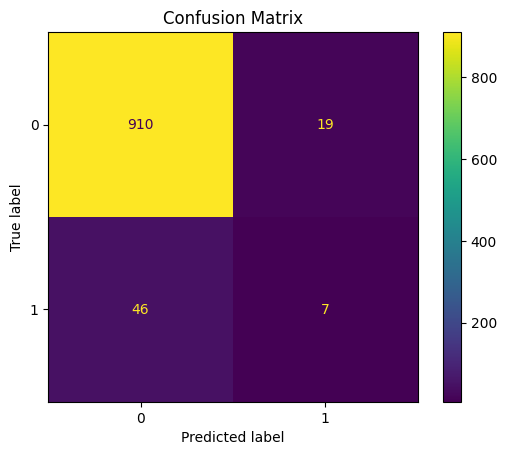

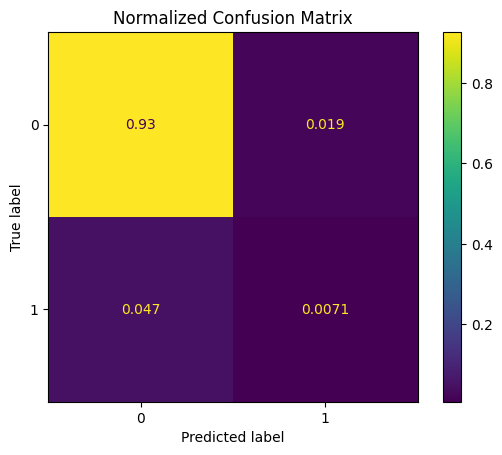

              precision    recall  f1-score   support

           0       0.95      0.98      0.97       929
           1       0.27      0.13      0.18        53

    accuracy                           0.93       982
   macro avg       0.61      0.56      0.57       982
weighted avg       0.92      0.93      0.92       982

Split 2:



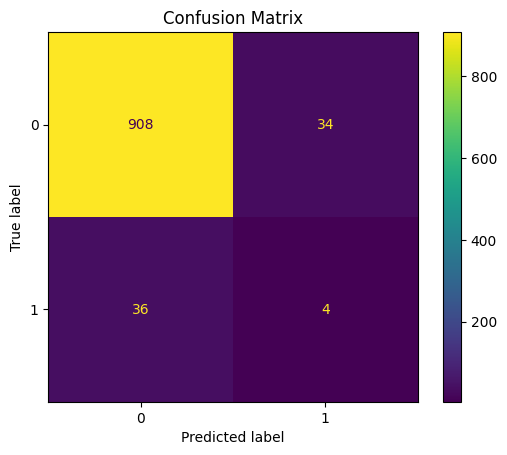

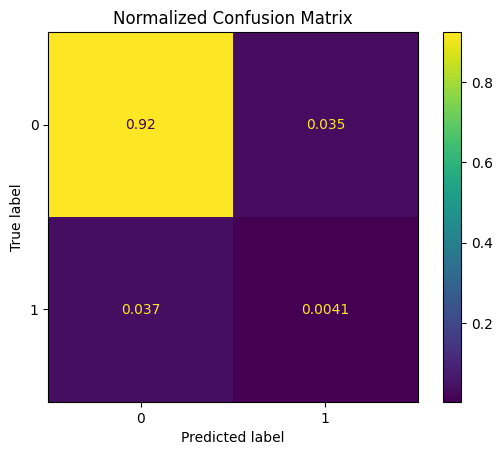

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       942
           1       0.11      0.10      0.10        40

    accuracy                           0.93       982
   macro avg       0.53      0.53      0.53       982
weighted avg       0.93      0.93      0.93       982

Split 3:



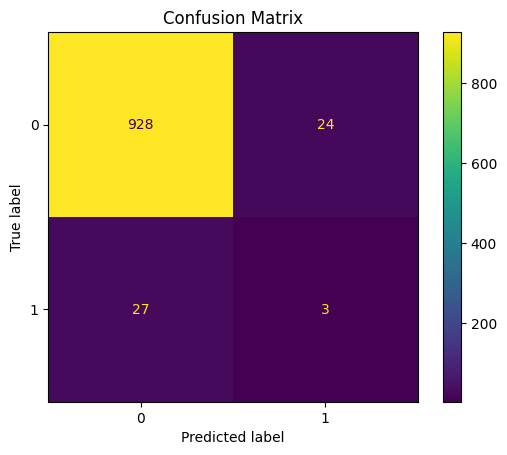

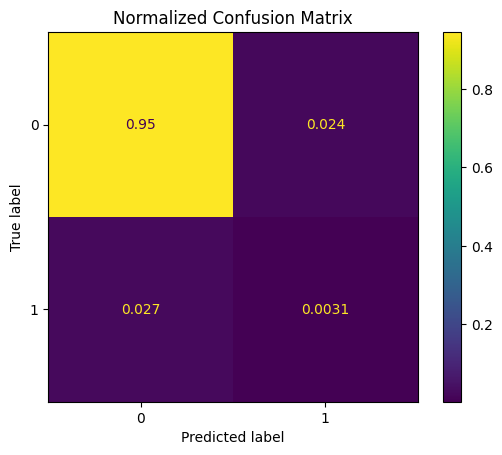

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       952
           1       0.11      0.10      0.11        30

    accuracy                           0.95       982
   macro avg       0.54      0.54      0.54       982
weighted avg       0.95      0.95      0.95       982

Split 4:



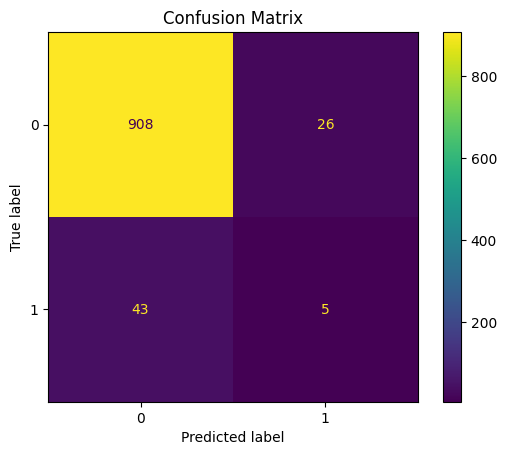

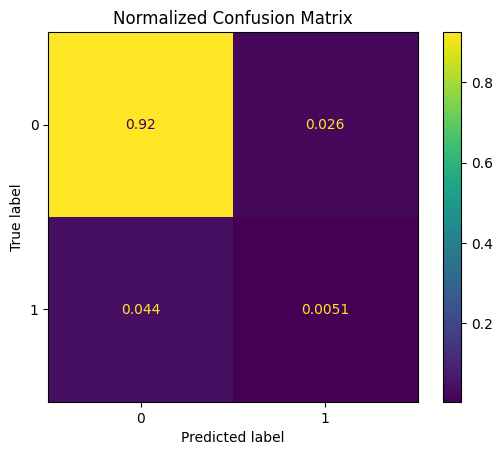

              precision    recall  f1-score   support

           0       0.95      0.97      0.96       934
           1       0.16      0.10      0.13        48

    accuracy                           0.93       982
   macro avg       0.56      0.54      0.54       982
weighted avg       0.92      0.93      0.92       982

Split 5:



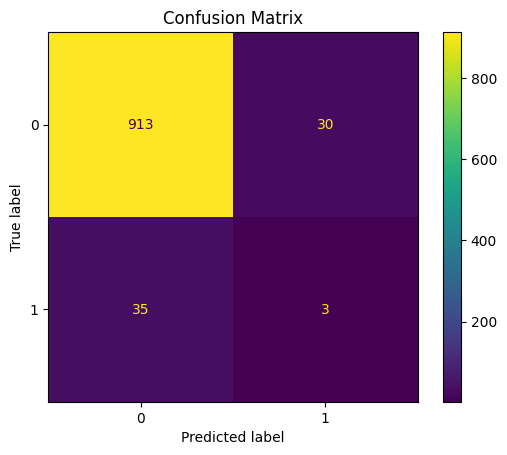

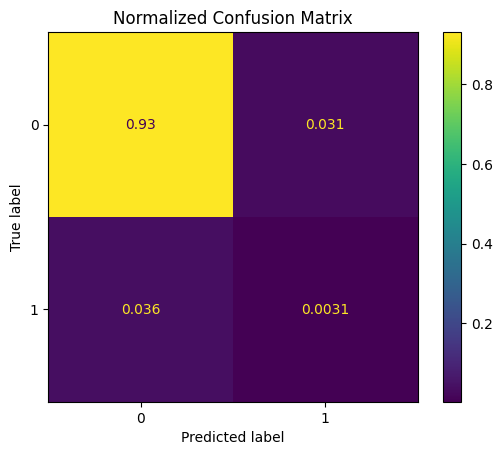

              precision    recall  f1-score   support

           0       0.96      0.97      0.97       943
           1       0.09      0.08      0.08        38

    accuracy                           0.93       981
   macro avg       0.53      0.52      0.53       981
weighted avg       0.93      0.93      0.93       981



In [40]:
mlp = MLPClassifier(hidden_layer_sizes=(30,30,30), max_iter=2000)
k_fold = KFold(n_splits=5, shuffle=True, random_state=42)
scaler = StandardScaler()


for i, (train_idxs, test_idxs) in enumerate(k_fold.split(X), 1):
    print(f"Split {i}:\n")

    x_train = X[train_idxs]
    x_test = X[test_idxs]
    y_train = Y[train_idxs]
    y_test = Y[test_idxs]

    # only train scaler on training data, pretend we haven't seen
    # the test data before. 
    scaler.fit(x_train)
    x_train = scaler.transform(x_train)
    x_test = scaler.transform(x_test)

    mlp.fit(x_train, y_train)
    predictions = mlp.predict(x_test)

    conf_mat = confusion_matrix(y_test, predictions)
    norm_conf_mat = confusion_matrix(y_test, predictions, normalize = 'all')

    conf_mat_display = ConfusionMatrixDisplay(conf_mat)
    conf_mat_display.plot()
    plt.title("Confusion Matrix")
    plt.show()

    norm_conf_mat_display = ConfusionMatrixDisplay(norm_conf_mat)
    norm_conf_mat_display.plot()
    plt.title("Normalized Confusion Matrix")
    plt.show()

    print(classification_report(y_test, predictions))

In [41]:
def get_new_keras_model(input_shape): 
    nn = Sequential()
    nn.add(Dense(30, input_shape = input_shape, activation="relu"))
    nn.add(Dense(30, activation = "relu"))
    nn.add(Dense(30, activation = "relu"))
    nn.add(Dense(1, activation = "sigmoid"))

    nn.compile(optimizer='adam', loss='binary_crossentropy', metrics = ['accuracy'])

    return nn

Split 1:

31/31 [==============================] - 0s 500us/step


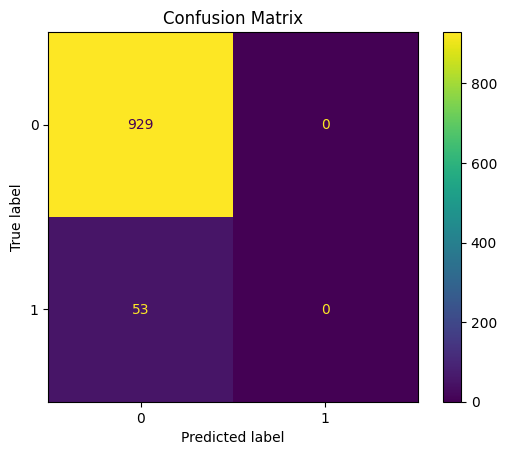

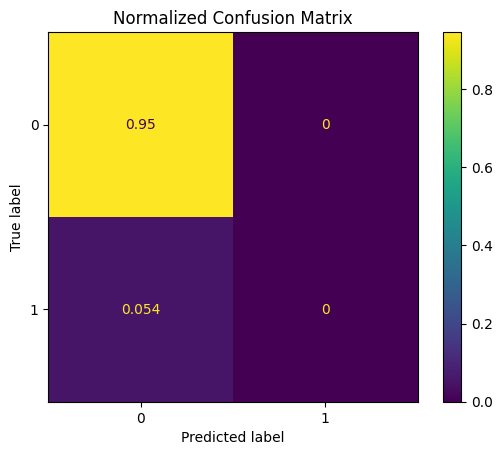

c:\Main Folder\Git Repositories\Data_Mining_II_Projects\Homework_1\.env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Main Folder\Git Repositories\Data_Mining_II_Projects\Homework_1\.env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Main Folder\Git Repositories\Data_Mining_II_Projects\Homework_1\.env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` param

              precision    recall  f1-score   support

           0       0.95      1.00      0.97       929
           1       0.00      0.00      0.00        53

    accuracy                           0.95       982
   macro avg       0.47      0.50      0.49       982
weighted avg       0.89      0.95      0.92       982

Split 2:

31/31 [==============================] - 0s 500us/step


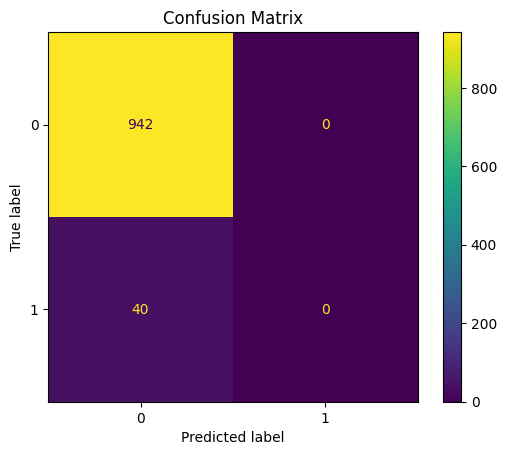

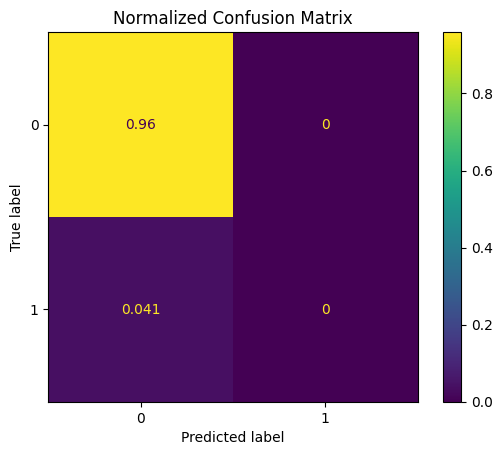

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       942
           1       0.00      0.00      0.00        40

    accuracy                           0.96       982
   macro avg       0.48      0.50      0.49       982
weighted avg       0.92      0.96      0.94       982

Split 3:



c:\Main Folder\Git Repositories\Data_Mining_II_Projects\Homework_1\.env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Main Folder\Git Repositories\Data_Mining_II_Projects\Homework_1\.env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Main Folder\Git Repositories\Data_Mining_II_Projects\Homework_1\.env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` param

31/31 [==============================] - 0s 467us/step


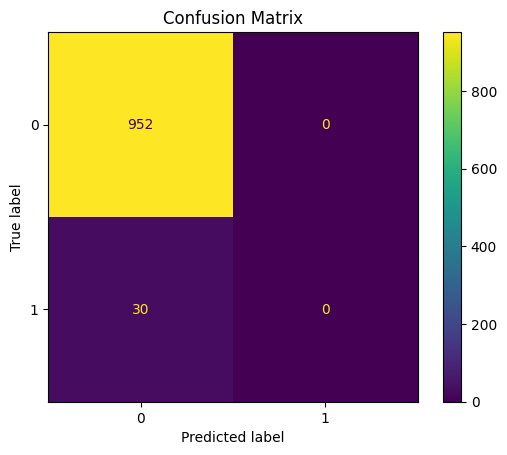

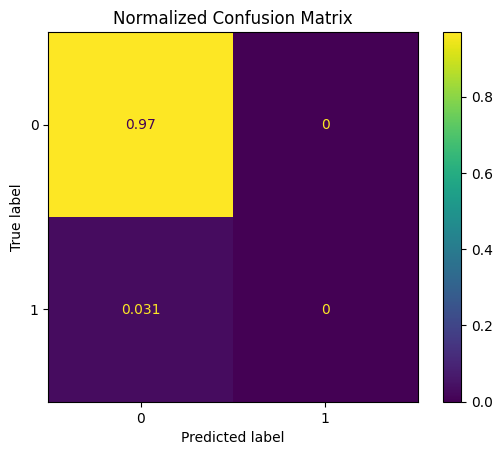

              precision    recall  f1-score   support

           0       0.97      1.00      0.98       952
           1       0.00      0.00      0.00        30

    accuracy                           0.97       982
   macro avg       0.48      0.50      0.49       982
weighted avg       0.94      0.97      0.95       982

Split 4:



c:\Main Folder\Git Repositories\Data_Mining_II_Projects\Homework_1\.env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Main Folder\Git Repositories\Data_Mining_II_Projects\Homework_1\.env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Main Folder\Git Repositories\Data_Mining_II_Projects\Homework_1\.env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` param

31/31 [==============================] - 0s 500us/step


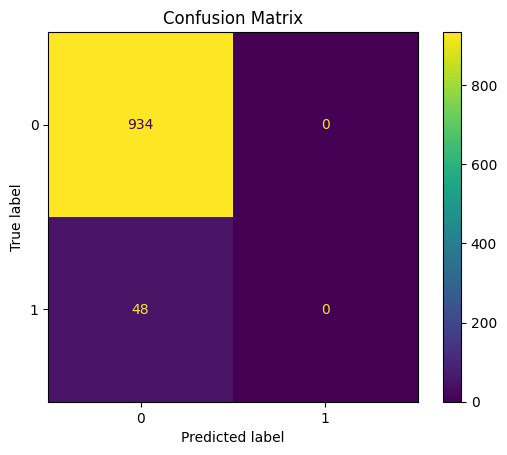

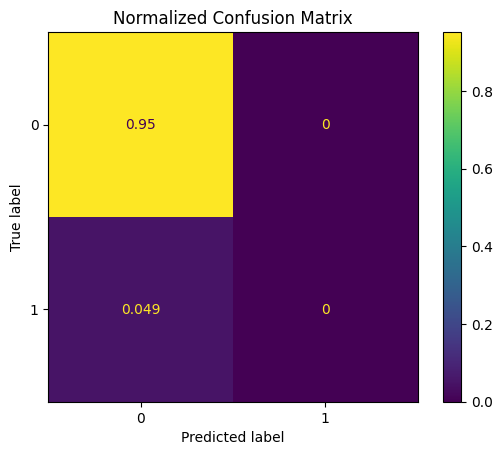

              precision    recall  f1-score   support

           0       0.95      1.00      0.97       934
           1       0.00      0.00      0.00        48

    accuracy                           0.95       982
   macro avg       0.48      0.50      0.49       982
weighted avg       0.90      0.95      0.93       982

Split 5:



c:\Main Folder\Git Repositories\Data_Mining_II_Projects\Homework_1\.env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Main Folder\Git Repositories\Data_Mining_II_Projects\Homework_1\.env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Main Folder\Git Repositories\Data_Mining_II_Projects\Homework_1\.env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` param

31/31 [==============================] - 0s 467us/step


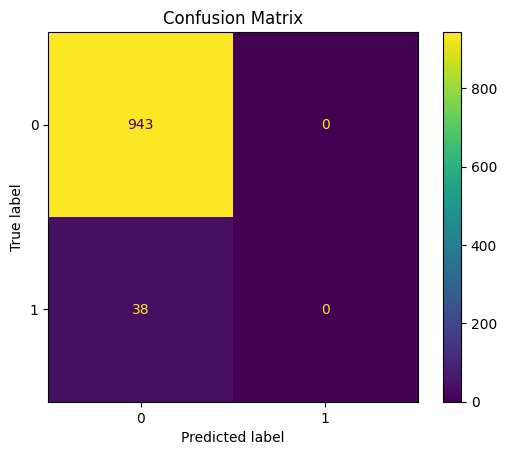

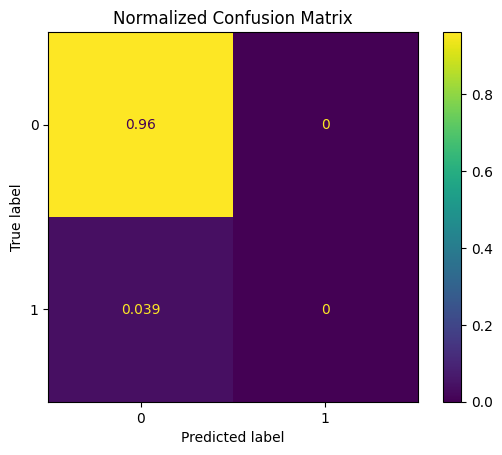

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       943
           1       0.00      0.00      0.00        38

    accuracy                           0.96       981
   macro avg       0.48      0.50      0.49       981
weighted avg       0.92      0.96      0.94       981



c:\Main Folder\Git Repositories\Data_Mining_II_Projects\Homework_1\.env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Main Folder\Git Repositories\Data_Mining_II_Projects\Homework_1\.env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Main Folder\Git Repositories\Data_Mining_II_Projects\Homework_1\.env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` param

In [42]:
for i, (train_idxs, test_idxs) in enumerate(k_fold.split(X), 1):
    print(f"Split {i}:\n")

    x_train = X[train_idxs]
    x_test = X[test_idxs]
    y_train = Y[train_idxs]
    y_test = Y[test_idxs]

    # only train scaler on training data, pretend we haven't seen
    # the test data before. 
    scaler.fit(x_train)
    x_train = scaler.transform(x_train)
    x_test = scaler.transform(x_test)

    nn = get_new_keras_model((X.shape[1],))
    early_stopping = EarlyStopping(monitor="val_loss", patience = 3)
    nn.fit(x_train, y_train, epochs = 200, validation_data = (x_test, y_test), verbose = False, callbacks = [early_stopping])

    predictions = np.round(nn.predict(x_test))

    conf_mat = confusion_matrix(y_test, predictions)
    norm_conf_mat = confusion_matrix(y_test, predictions, normalize = 'all')

    conf_mat_display = ConfusionMatrixDisplay(conf_mat)
    conf_mat_display.plot()
    plt.title("Confusion Matrix")
    plt.show()

    norm_conf_mat_display = ConfusionMatrixDisplay(norm_conf_mat)
    norm_conf_mat_display.plot()
    plt.title("Normalized Confusion Matrix")
    plt.show()

    print(classification_report(y_test, predictions))